In [9]:
import numpy as np
import matplotlib.pyplot as plt

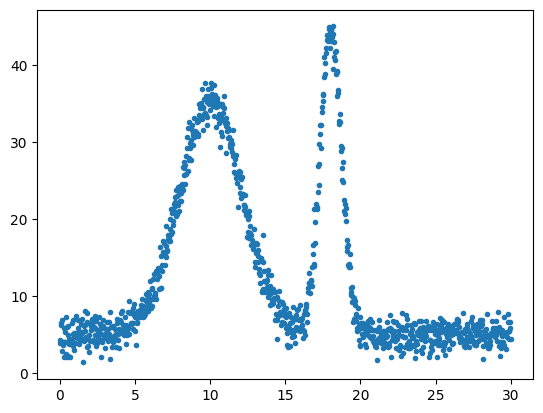

In [10]:
def my_gauss_func(x, params):
    # 定义模型函数
    t1 = params[1] * np.exp(-((x - params[2]) / params[3]) ** 2)
    t2 = params[4] * np.exp(-((x - params[5]) / params[6]) ** 2)
    y = params[0] + t1 + t2
    return y


n = 1000
er =0.03
p = [5, 30, 10, 3,40,18,1]
x = np.linspace(0, 30, n)
y0 = my_gauss_func(x, p)
ey = np.max(y0) * er * np.random.randn(n)
y = y0 + ey
plt.plot(x, y, ".")

In [11]:
from scipy.optimize import leastsq

# 定义残差函数
def res_func(params, x, y):
    return y - my_gauss_func(x, params)

# 初始参数猜测
initial_guess = [0, 35, 8, 5, 45, 17, 2]

# 进行拟合
result = leastsq(res_func, initial_guess, args=(x, y), full_output=True)

In [12]:
# 定义残差函数
def residuals(params, x, y, my_func):
    return y - my_func(x, params)

r = residuals(result[0], x, y, my_gauss_func)

inv_H = result[1]
# print("逆 hessian矩阵 inv_H： ", inv_H)
# print("参数的协方差矩阵：", inv_H * r.var())
print("参数的方差为：", np.diagonal(inv_H) * r.var())

参数的方差为： [3.48403362e-03 2.32600946e-02 1.39272439e-04 3.42505925e-04
 6.52679495e-02 2.72398375e-05 5.84023331e-05]


# BootStrap (自举法)

Bootstrap 方法是一种非参数统计方法，常用于估计参数的分布、均值、方差以及置信区间。它的核心思想是通过对数据进行有放回的重采样，模拟抽样分布。以下是详细的解释和公式：

---

### **1. Bootstrap 的基本步骤**
假设我们有一个包含 $ n $ 个观测值的数据集 $ \{x_1, x_2, \ldots, x_n\} $，希望估计某个统计量 $ \theta $（例如均值、方差、回归系数等）的分布。

1. **生成重采样数据集**：
   - 从原始数据集中**有放回地抽样** $ n $ 次，得到一个大小为 $ n $ 的新数据集，记为 $ \{x_1^*, x_2^*, \ldots, x_n^*\} $。
   - 这样的重采样过程可以重复 $ B $ 次，得到 $ B $ 个重采样数据集。

2. **计算统计量**：
   - 对每个重采样数据集，计算统计量 $ \theta^*_b $（例如均值或方差），其中 $ b = 1, 2, \ldots, B $。

3. **估计统计量的分布**：
   - 根据 $ B $ 个 $ \theta^*_b $ 值，近似原始统计量的抽样分布。

---

### **2. 参数的均值和方差**
通过 $ B $ 次重采样的结果，可以估计统计量的均值和方差：

- **均值的估计**：
  $$
  \hat{\theta} = \frac{1}{B} \sum_{b=1}^B \theta^*_b
  $$

- **方差的估计**：
  $$
  \text{Var}(\hat{\theta}) = \frac{1}{B-1} \sum_{b=1}^B \left(\theta^*_b - \hat{\theta}\right)^2
  $$

---

### **3. 置信区间的估计**
Bootstrap 提供多种方法来计算统计量的置信区间。

#### **1) Percentile 方法**
直接取重采样分布的分位数：
- 对 $ \theta^*_b $ 排序。
- 置信区间为 $ \left[\theta^*_{\alpha/2}, \theta^*_{1-\alpha/2}\right] $，其中 $ \theta^*_{\alpha/2} $ 和 $ \theta^*_{1-\alpha/2} $ 分别是第 $ \alpha/2 $ 和 $ 1-\alpha/2 $ 的分位数。

#### **2) Bias-Corrected and Accelerated (BCa) 方法**
考虑了偏差和加速因子的调整：
$$
CI = \left[\theta^*_{z_1}, \theta^*_{z_2}\right]
$$
其中 $ z_1 $ 和 $ z_2 $ 是经过调整后的分位数，基于偏差校正 $ z_0 $ 和加速因子 $ a $。

#### **3) 正态方法**
假设 $ \theta^* $ 服从正态分布，置信区间为：
$$
CI = \left[\hat{\theta} - z_{\alpha/2} \cdot \text{SE}, \hat{\theta} + z_{\alpha/2} \cdot \text{SE}\right]
$$
其中：
- $ \text{SE} = \sqrt{\text{Var}(\hat{\theta})} $ 是标准误差。
- $ z_{\alpha/2} $ 是标准正态分布的分位数。

---

### **4. Bootstrap 的优点和注意事项**
#### **优点**：
1. 不需要对数据的分布做强假设。
2. 可用于复杂统计量的估计。
3. 简单易实现。

#### **注意事项**：
1. $ B $ 的值应足够大（通常 $ B > 1000 $）。
2. 重采样的结果可能对小样本数据集不稳定。
3. 如果数据有很强的依赖性（如时间序列），需要调整重采样方法，如 Block Bootstrap。


#### **关于自举样本的数量B**
1. 一般境况下B > 1000 且 B = n
2. 也有的情况取 $B = n(ln(n))^2$
3. 自举样本数B最大为n!

In [14]:
import numpy as np
import scipy.optimize as spopt

# 定义残差函数
def res_func(params, x, y):
    return y - my_gauss_func(x, params)

def bootstrap_parameter_estimation(x, y, residuals, p0, B=1000, alpha=0.05):
    """
    使用 Bootstrap 方法估计模型参数的分布、均值、方差和置信区间。
    
    参数:
        x (array-like): 自变量数据。
        y (array-like): 因变量数据。
        residuals (callable): 计算残差的函数，形式 residuals(p, x, y)。
        p0 (array-like): 初始参数猜测。
        B (int): 重采样次数。
        alpha (float): 用于计算置信区间的显著性水平。
    
    返回:
        param_means (array-like): 参数均值。
        param_vars (array-like): 参数方差。
        param_cis (list of tuples): 每个参数的置信区间 (alpha/2, 1-alpha/2)。
    """
    n = len(y)
    param_samples = []

    # 原始数据的拟合，用于记录原始估计值
    original_params, _ = spopt.leastsq(residuals, p0, args=(x, y))
    
    for _ in range(B):
        # 对数据进行有放回的重采样
        indices = np.random.choice(n, n, replace=True) # 为了保证x和y对应，所以这里抽样的是索引。
        x_sample = x[indices]
        y_sample = y[indices]
        
        # 对重采样的数据进行拟合
        params, _ = spopt.leastsq(residuals, p0, args=(x_sample, y_sample))
        param_samples.append(params)
    
    param_samples = np.array(param_samples)
    
    # 计算参数的均值和方差
    param_means = np.mean(param_samples, axis=0) #axis=0 表示对于每一个参数的分布求平均
    param_vars = np.var(param_samples, axis=0, ddof=1) #ddof=1表示求的是样本方差
    
    # 计算参数的置信区间
    param_cis = []
    for i in range(param_samples.shape[1]):
        lower = np.percentile(param_samples[:, i], 100 * alpha / 2)  #alpha=0.05  => 2.5%
        upper = np.percentile(param_samples[:, i], 100 * (1 - alpha / 2)) #alpha=0.05  => 97.5%
        param_cis.append((lower, upper))
    
    return param_means, param_vars, param_cis


param_means, param_vars, param_cis = bootstrap_parameter_estimation(x, y, res_func, initial_guess, B=n) # 一般自举样本数等于样本数

print("参数均值:", param_means)
print("参数方差:", param_vars)
print("参数95%置信区间:", param_cis)


参数均值: [ 4.96041574 30.21139136 10.01642366  2.98555842 39.68542212 18.00505202
  1.00598029]
参数方差: [3.20361833e-03 2.78427669e-02 1.50591339e-04 3.46498318e-04
 5.51793110e-02 3.02249256e-05 6.60923463e-05]
参数95%置信区间: [(4.8489471662709445, 5.071914208613976), (29.865240474496662, 30.538243973900784), (9.992944018649734, 10.040524014364022), (2.9506451376248632, 3.0198681733902997), (39.19938240415795, 40.138429839219846), (17.99458894500496, 18.015422799830645), (0.9900707952195973, 1.0210691519360673)]


In [15]:
# 对比两个的结果：
print("公式计算：")
print(np.diagonal(inv_H) * r.var())
print("bootstrap 计算：")
print(param_vars)

公式计算：
[3.48403362e-03 2.32600946e-02 1.39272439e-04 3.42505925e-04
 6.52679495e-02 2.72398375e-05 5.84023331e-05]
bootstrap 计算：
[3.20361833e-03 2.78427669e-02 1.50591339e-04 3.46498318e-04
 5.51793110e-02 3.02249256e-05 6.60923463e-05]
